# Black Litterman with Investor Views Optimization: Oldest Country ETFs
# Charts

## 1. Data Fetching

### 1.1 Model configuration

In [8]:
import os
import sys
import datetime as dt
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import cvxportfolio as cp
import alphamodel as am

config = {'name': 'bl_sim_charts',
          'universe':
              {'list': ['SPY', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWS', 'EWU', 'EWW'],
               'ticker_col': 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD"},
          'model':
              {'start_date': '19970102',
               'end_date': '20091231',
               'halflife': 65,
               'min_periods': 3,
               'hidden_states': 2,
               'train_len': 1700,
               'process': 'none',
               'data_dir': '/Users/razvan/PyRepo/research_masc/data_store/bl/',
               'returns':
                   {'sampling_freq': 'daily'},
               'covariance':
                    {'method' : 'SS',
                     'sampling_freq' : 'monthly',
                     'train_days': 360}
              }
         }

# Logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### 1.2 Fetch return data

In [9]:
# Fetch returns / volumes
ss = am.SingleStockBLEWM(config)
ss.train(force=True)

# Realized Data for Simulation
prices = ss.get('prices', 'realized', ss.cfg['returns']['sampling_freq']).iloc[1:,:]
returns = ss.get('returns', 'realized', ss.cfg['returns']['sampling_freq'])
volumes = ss.get('volumes', 'realized', ss.cfg['returns']['sampling_freq'])
sigmas = ss.get('sigmas', 'realized', ss.cfg['returns']['sampling_freq'])

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key=ss.risk_free_symbol)

downloading SPY from 19970102 to 20091231
downloading EWA from 19970102 to 20091231
downloading EWC from 19970102 to 20091231
downloading EWG from 19970102 to 20091231
downloading EWH from 19970102 to 20091231
downloading EWJ from 19970102 to 20091231
downloading EWS from 19970102 to 20091231
downloading EWU from 19970102 to 20091231
downloading EWW from 19970102 to 20091231
downloading USDOLLAR from 19970102 to 20091231
Removing these days from dataset:
            nan price
1999-04-02          9
2001-09-13          9
2001-09-14          9
2007-01-02          9
2007-04-06          9
          remaining nan price
SPY                         0
EWA                         0
EWC                         0
EWG                         0
EWH                         0
EWJ                         0
EWS                         0
EWU                         0
EWW                         0
USDOLLAR                   25
Proceeding with forward fills to remove remaining NaNs


### 1.3 Plot return data

In [10]:
# Process returns for charting
chart_returns = returns[returns.index >= dt.datetime(2005, 1, 2)]
chart_growth = (chart_returns + 1).cumprod()
chart_returns_cum = chart_growth - 1
chart_returns_cum = chart_returns_cum.stack().reset_index()
chart_returns_cum.columns = ['Date', 'Ticker', 'Value']

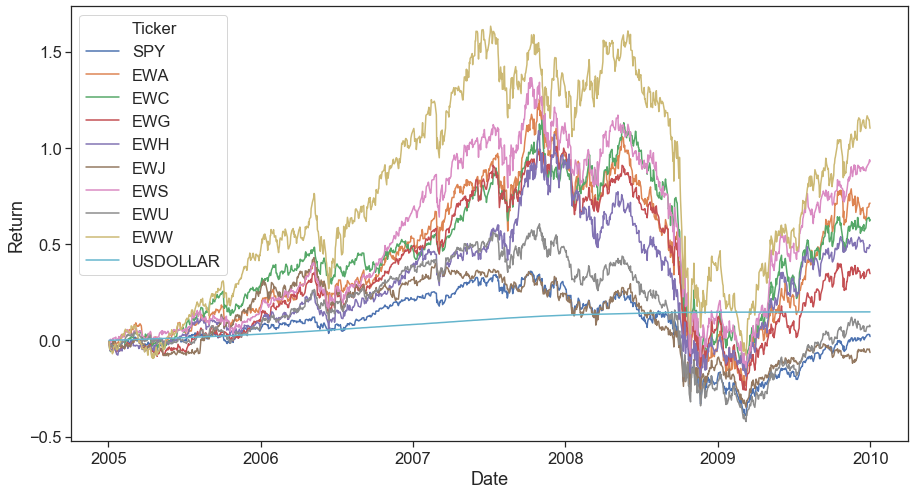

In [11]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    data = chart_returns_cum
    ax = sns.lineplot(x='Date', y='Value', hue='Ticker', data=data)
    ax.set(xlabel='Date', ylabel='Return')
    plt.savefig(ss.cfg['data_dir'] + 'bl_asset_returns.png')

## 2. Model fitting

### 2.1 Extract Black Litterman equilibrium returns

In [12]:
# Aggregate market stats for cal
market_stats = pd.DataFrame({'MarketCap/GDP': [1.25, 1, 1.25, 0.45, 3.5, 0.8, 2, 1.25, 0.3, 0],
                             'GDP': [2543500, 150000, 239000, 853000, 22500, 1037500, 10000, 422500, 164500, 0]},
                            index=ss.universe + ['USDOLLAR'])
market_stats.loc[:, 'MarketCap'] = market_stats.loc[:, 'MarketCap/GDP'] * market_stats.loc[:, 'GDP']
market_stats.loc[:, 'MarketCap Weights'] = market_stats.loc[:, 'MarketCap'] / market_stats.loc[:, 'MarketCap'].sum()
market_stats

,MarketCap/GDP,GDP,MarketCap,MarketCap Weights
SPY,1.25,2543500,3179375.0,0.576162
EWA,1.00,150000,150000.0,0.027183
EWC,1.25,239000,298750.0,0.054139
EWG,0.45,853000,383850.0,0.069561
EWH,3.50,22500,78750.0,0.014271
EWJ,0.80,1037500,830000.0,0.150411
EWS,2.00,10000,20000.0,0.003624
EWU,1.25,422500,528125.0,0.095706
EWW,0.30,164500,49350.0,0.008943
USDOLLAR,0.00,0,0.0,0.000000


In [13]:
# Generate market cap weights pandas.Series
w_mktcap = pd.Series(index=market_stats.index, data=market_stats.loc[:, 'MarketCap Weights'])
w_mktcap['USDOLLAR'] = 0.

### 2.2 Generate BL posterior returns/covariance

In [14]:
# Parameters that match simulations
risk_aversion = 2.5
confidence = 0.8
vconf = 0.7
gamma_risk = 0.1
gamma_trade = 0.1
gamma_hold = 0

#### 2.2.1 Correct View

In [15]:
# Predicted Data for Optimization
# US underperforms Germany 4% per year - correct view
ss.predict(w_market_cap_init=w_mktcap, risk_aversion=risk_aversion, c=confidence,
           P_view=np.array([-1, 0, 0, 1, 0, 0, 0, 0, 0, 0]), Q_view=np.array(0.04 / 252),
           view_confidence=vconf
          )

# Black Litterman output
r_cor_pred = ss.get('returns', 'predicted')
covariance_cor_pred = ss.get('covariance', 'predicted')
volumes_cor_pred = ss.get('volumes', 'predicted')
sigmas_cor_pred = ss.get('sigmas', 'predicted')

Typical variance of returns: 0.000319834


#### 2.2.2 Incorrect View

In [16]:
# Predicted Data for Optimization
# US outperforms Germany 4% per year - correct view
ss.predict(w_market_cap_init=w_mktcap, risk_aversion=risk_aversion, c=confidence,
           P_view=np.array([1, 0, 0, -1, 0, 0, 0, 0, 0, 0]), Q_view=np.array(0.04 / 252),
           view_confidence=vconf
          )

# Black Litterman output
r_incor_pred = ss.get('returns', 'predicted')
covariance_incor_pred = ss.get('covariance', 'predicted')
volumes_incor_pred = ss.get('volumes', 'predicted')
sigmas_incor_pred = ss.get('sigmas', 'predicted')

Typical variance of returns: 0.000319834


## 3. Simulation Results

### Input Data

In [17]:
# Start and end date
start_date = dt.datetime(2005, 1, 2)
end_date = dt.datetime.strptime(config['model']['end_date'], '%Y%m%d')

# Predicted costs
optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1.,
                                   sigma=sigmas_cor_pred,
                                   volume=volumes_cor_pred)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

## 3.1 Single Period Optimization for Allocation

### 3.1.1 Market Capitalization Weights

In [18]:
%%time

# Market cap weights
mktcap_rebalance = cp.Hold(trading_freq="once")

# Backtest
market_cap_w = simulator.run_multiple_backtest(1E6*w_mktcap,
                                               start_time=start_date,  end_time=end_date,
                                               policies=[mktcap_rebalance],
                                               loglevel=logging.WARNING, parallel=True)
market_cap_w[0].summary()

Number of periods                              1259
Initial timestamp               2005-01-03 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                          5.262
Excess return (%)                             2.501
Excess risk (%)                              24.951
Sharpe ratio                                  0.100
Max. drawdown                                57.101
Turnover (%)                                  0.000
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.004
CPU times: user 48.9 ms, sys: 43.1 ms, total: 91.9 ms
Wall time: 21.1 s


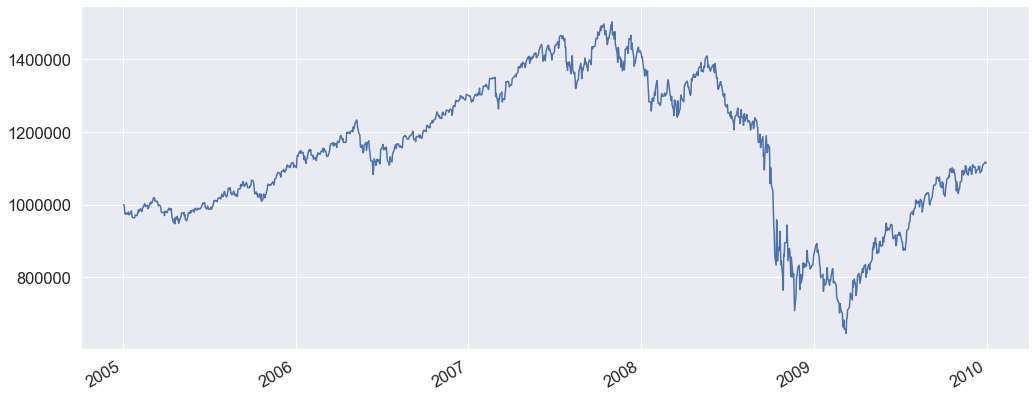

In [19]:
market_cap_w[0].v.plot(figsize=(17,7))

### 3.1.2 Black Litterman Returns & Covariance Simulation

In [20]:
# Optimization parameters
leverage_limit = cp.LeverageLimit(1)
fully_invested = cp.ZeroCash()
long_only = cp.LongOnly()

#### 3.1.2.1 Correct View

In [21]:
%%time

# Covariance setup
bl_cor_risk_model = cp.FullSigma(covariance_cor_pred)

# Optimization policy
bl_cor_policy = cp.SinglePeriodOpt(return_forecast=r_cor_pred, 
                                costs=[gamma_risk*bl_cor_risk_model,
                                       gamma_trade*optimization_tcost,
                                       gamma_hold*optimization_hcost],
                                constraints=[leverage_limit, fully_invested, long_only],
                                trading_freq='hour')

# Backtest
bl_cor_results = simulator.run_multiple_backtest(1E6*w_mktcap,
                                           start_time=start_date,  end_time=end_date,
                                           policies=[bl_cor_policy],
                                           loglevel=logging.WARNING, parallel=True)
bl_cor_results[0].summary()

2020-09-13 17:41:18,067 BasePolicy: trading_freq hour is not supported, the policy will only trade once.


Number of periods                              1259
Initial timestamp               2005-01-03 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                          9.372
Excess return (%)                             6.611
Excess risk (%)                              28.949
Sharpe ratio                                  0.228
Max. drawdown                                61.642
Turnover (%)                                 23.065
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.004
CPU times: user 68.9 ms, sys: 43.3 ms, total: 112 ms
Wall time: 29.3 s


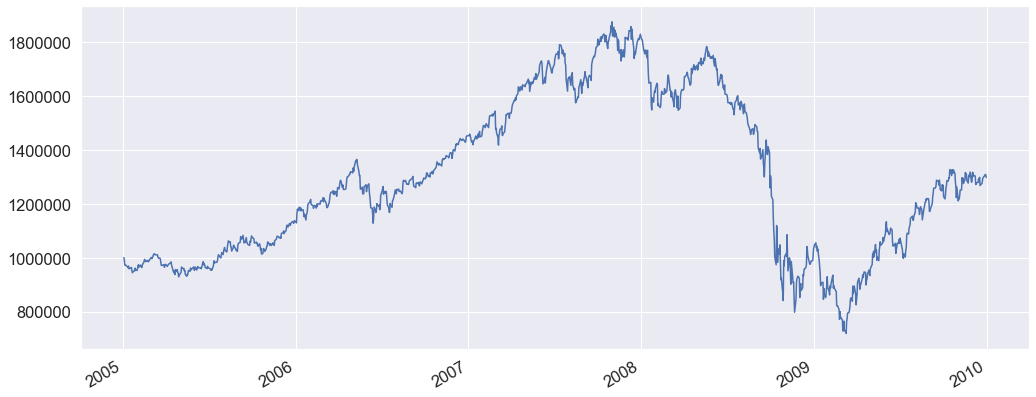

In [22]:
bl_cor_results[0].v.plot(figsize=(17,7))

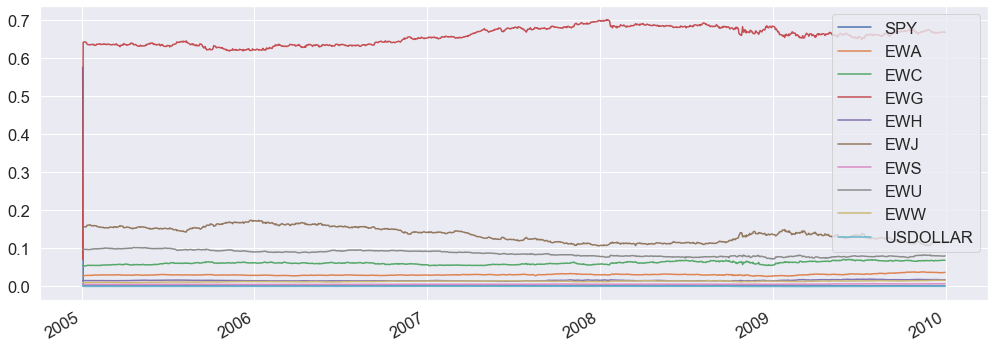

In [23]:
bl_cor_results[0].w.plot(figsize=(17,6))

#### 3.1.2.2 Incorrect View

In [24]:
%%time

# Covariance setup
bl_incor_risk_model = cp.FullSigma(covariance_incor_pred)

# Optimization policy
bl_incor_policy = cp.SinglePeriodOpt(return_forecast=r_incor_pred, 
                                costs=[gamma_risk*bl_incor_risk_model,
                                       gamma_trade*optimization_tcost,
                                       gamma_hold*optimization_hcost],
                                constraints=[leverage_limit, fully_invested, long_only],
                                trading_freq='hour')

# Backtest
bl_incor_results = simulator.run_multiple_backtest(1E6*w_mktcap,
                                           start_time=start_date,  end_time=end_date,
                                           policies=[bl_incor_policy],
                                           loglevel=logging.WARNING, parallel=True)
bl_incor_results[0].summary()

2020-09-13 17:41:48,552 BasePolicy: trading_freq hour is not supported, the policy will only trade once.


Number of periods                              1259
Initial timestamp               2005-01-03 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                          4.743
Excess return (%)                             1.981
Excess risk (%)                              24.582
Sharpe ratio                                  0.081
Max. drawdown                                56.343
Turnover (%)                                  2.980
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.004
CPU times: user 135 ms, sys: 82.3 ms, total: 217 ms
Wall time: 27.2 s


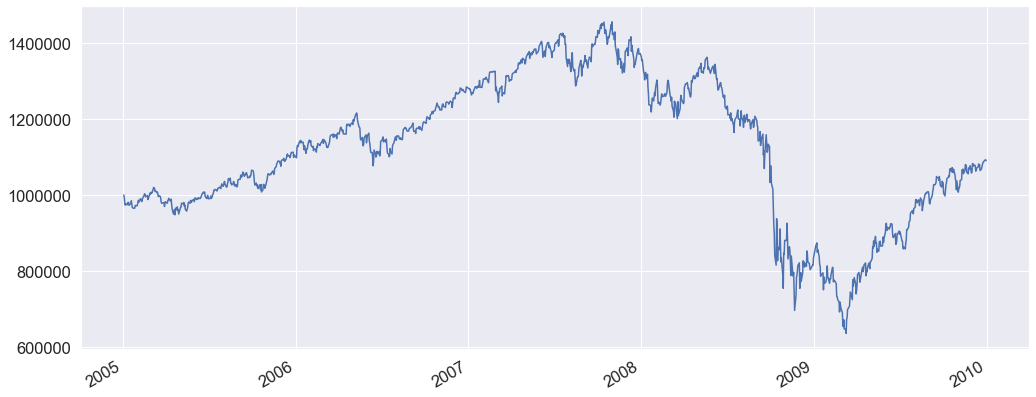

In [25]:
bl_incor_results[0].v.plot(figsize=(17,7))

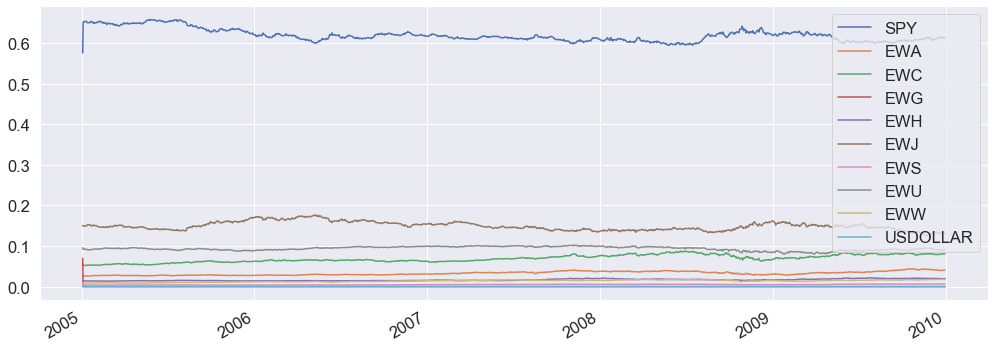

In [26]:
bl_incor_results[0].w.plot(figsize=(17,6))

### 3.1.3 Weight Allocation Difference

In [27]:
# Market capitalization weights
w_mktcap
w_mktcap.name = 'Equilibrium'

# Correct view weights
w_bl_cor = bl_cor_results[0].w.iloc[1,:]
w_bl_cor.name = 'Correct View'

#Incorrect view weights
w_bl_incor = bl_incor_results[0].w.iloc[1,:]
w_bl_incor.name = 'Incorrect View'

# Construct weight dataframe
bl_weights = pd.concat([w_mktcap, w_bl_cor, w_bl_incor], axis=1)
bl_weights = bl_weights.stack().reset_index()
bl_weights.columns = ['Ticker', 'Scenario', 'Value']

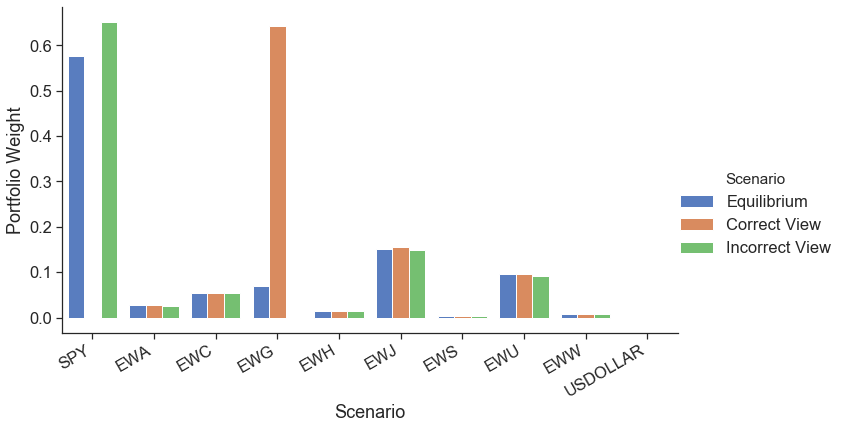

In [28]:
%matplotlib inline  

with sns.axes_style('ticks', {'figure.figsize': (15,8), 'font_scale': 1.5}):
    data = bl_weights
    ax = sns.catplot(x='Ticker', y='Value', hue='Scenario', data=data, kind='bar', palette='muted', height=10)
    ax.set(xlabel='Scenario', ylabel='Portfolio Weight')
    ax.fig.set_size_inches(12,5)
    plt.xticks(rotation=30, horizontalalignment='right')
    plt.savefig(ss.cfg['data_dir'] + 'bl_view_weights.png', bbox_inches="tight")

### 3.1.4 View Confidence Sharpe Difference

In [31]:
# Grab Black-Litterman view simulation results
bl_eq_results = market_cap_w[0]
bl_eq = pd.DataFrame.from_dict({'Ex-Post View': ['Equilibrium'],
                                'view_confidence': [0],
                                'excess_return': [bl_eq_results.excess_returns.mean() * 100 * bl_eq_results.ppy],
                                'excess_risk': [bl_eq_results.excess_returns.std() * 100 * np.sqrt(bl_eq_results.ppy)]})

bl_cor_view = pd.read_csv(ss.cfg['data_dir'] + 'bl_ewm_corview.csv')
bl_cor = bl_cor_view[['view_confidence', 'excess_return', 'excess_risk']].copy()
bl_cor.loc[:, 'Ex-Post View'] = 'Correct View'

bl_incor_view = pd.read_csv(ss.cfg['data_dir'] + 'bl_ewm_incorview.csv')
bl_incor = bl_incor_view[['view_confidence', 'excess_return', 'excess_risk']].copy()
bl_incor.loc[:, 'Ex-Post View'] = 'Incorrect View'

bl_results = pd.concat([bl_eq, bl_cor, bl_incor])
bl_results.loc[:, 'sharpe'] = bl_results.loc[:, 'excess_return'] / bl_results.loc[:, 'excess_risk']
bl_results

,Ex-Post View,view_confidence,excess_return,excess_risk,sharpe
0,Equilibrium,0.00,2.500869,24.951322,0.100230
0,Correct View,0.00,2.500869,24.951322,0.100230
1,Correct View,0.05,2.500870,24.951323,0.100230
2,Correct View,0.10,2.957047,25.311305,0.116827
3,Correct View,0.15,3.707191,25.965209,0.142775
4,Correct View,0.20,4.369043,26.587741,0.164325
5,Correct View,0.25,4.937363,27.149262,0.181860
6,Correct View,0.30,5.428647,27.650891,0.196328
7,Correct View,0.35,5.856646,28.098082,0.208436
8,Correct View,0.40,6.232410,28.497139,0.218703


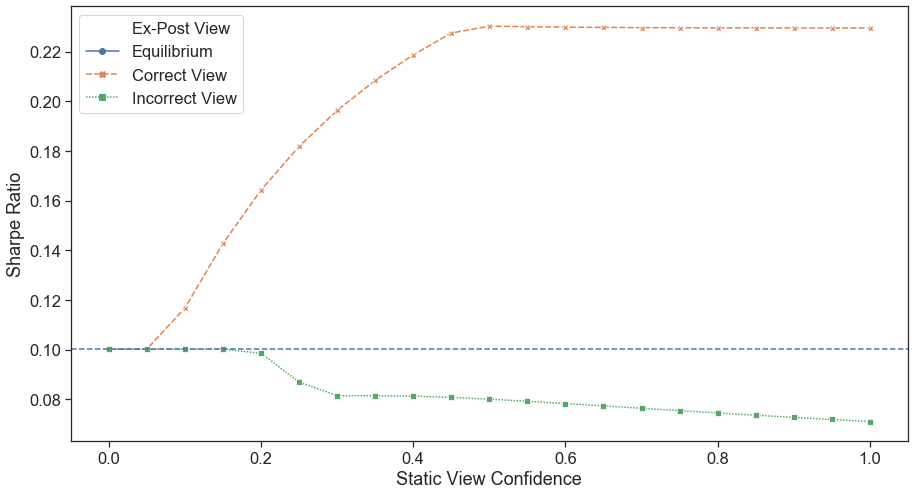

In [32]:
plt.figure(figsize=(15,8))

with sns.axes_style('ticks', {'font_scale': 1.5}):
    data = bl_results
    ax = sns.lineplot(x='view_confidence', y='sharpe', hue='Ex-Post View', style='Ex-Post View', data=data, markers=True)
    ax.set(xlabel='Static View Confidence', ylabel='Sharpe Ratio')
    ax.axhline(0.100230, ls='--')
    plt.savefig(ss.cfg['data_dir'] + 'bl_view_sharpe.png')